In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
from matplotlib import pyplot as plt

In [78]:
import random
import numpy as np
import torch
import gymnasium as gym
from policies.network import get_MLP
from utils.replay_buffer import ReplayBuffer

# SAC

### Initialize

In [79]:

from utils.replay_buffer import ReplayBuffer
from torch import nn
from policies.sac import SAC
from policies.actor.continuous_actor import ContinuousSoftActor
env = gym.make('Pendulum-v1', max_episode_steps=200)
env.reset(seed=0)


(array([ 0.6520163 ,  0.758205  , -0.46042657], dtype=float32), {})

In [80]:
actor_module = ContinuousSoftActor(state_dim=3, 
                                   action_dim=1, 
                                   act_bias=np.array([0]),
                                   act_scale=np.array([2]))
critic_module = get_MLP(
    num_features=3 + 1,
    num_actions=1,
    hidden_layers=[128]
)
critic2_module = get_MLP(
    num_features=3 + 1,
    num_actions=1,
    hidden_layers=[128]
)
sac_policy = SAC(
    q1=critic_module,
    q2=critic2_module,
    pi=actor_module,
    state_dim=3,
    action_dim=1,
    lr_q=1e-4,
    lr_pi=1e-4,
    auto_alpha=True
)
results_sac = []

### Compute

In [81]:
buffer = ReplayBuffer(capacity=10000)
minimal_size = 100
batch_size = 64

for epi in range(500):
    observation, info = env.reset(seed=0)
    terminated = False
    truncated = False
    epi_len = 0
    total_return = 0

    while not terminated and not truncated:
        action = sac_policy(torch.from_numpy(observation.reshape(1, -1)))
        prev_obs = observation
        observation, reward, terminated, truncated, info = env.step(action.detach().numpy().reshape(-1))
        buffer.add(prev_obs, action, reward, observation, terminated, truncated)
        epi_len += 1
        total_return += reward

        if buffer.size() > minimal_size:
            sampled = buffer.sample(batch_size)
            sac_policy.update(sampled)
    
    print("epi: {}; len: {}; return: {}".format(epi, epi_len, total_return))
    results_sac.append((epi_len, total_return))
env.close()


epi: 0; len: 200; return: -1068.5549880588576
epi: 1; len: 200; return: -1028.684377279125
epi: 2; len: 200; return: -1415.044237840663
epi: 3; len: 200; return: -1493.917381939243
epi: 4; len: 200; return: -1426.922664138777
epi: 5; len: 200; return: -1417.737340630197
epi: 6; len: 200; return: -1311.0933582000355
epi: 7; len: 200; return: -1235.603758139541
epi: 8; len: 200; return: -1226.0718666872783
epi: 9; len: 200; return: -1198.9560522635943
epi: 10; len: 200; return: -1463.606378632664
epi: 11; len: 200; return: -1554.7420144091648
epi: 12; len: 200; return: -1555.2163175652922
epi: 13; len: 200; return: -1552.5227108487336
epi: 14; len: 200; return: -1531.450583473187
epi: 15; len: 200; return: -1516.8404435129303
epi: 16; len: 200; return: -1515.5736317593062
epi: 17; len: 200; return: -1515.1870853669016
epi: 18; len: 200; return: -1510.9657480122842
epi: 19; len: 200; return: -1507.5553716040865
epi: 20; len: 200; return: -1494.112679046889


KeyboardInterrupt: 

In [ ]:
observation, info = env.reset(seed=0)
total_return = 0
epi_len = 0

for epi in range(200):
    states, rewards, actions, next_states, terminations = [], [], [], [], []
    # while not terminated and not truncated:
    for timestep in range(128):
        action = sac_policy(observation)
        prev_obs = observation
        observation, reward, terminated, truncated, info = env.step(torch.from_numpy(action))

        states.append(prev_obs)
        rewards.append(reward)
        actions.append(action)
        next_states.append(observation)
        terminations.append(terminated)
        
        total_return += reward
        epi_len += 1
        if terminated or truncated:
            print("len: {}; return: {}".format(epi_len, total_return))
            results_sac.append((epi_len, total_return))
            total_return = 0
            epi_len = 0
            env.reset()

    print("update")
    sac_policy.learn(
        torch.from_numpy(np.array(states, copy=False)),
        torch.from_numpy(np.array(actions, copy=False)),
        torch.from_numpy(np.array(next_states, copy=False)),
        torch.from_numpy(np.array(rewards, copy=False)),
        torch.from_numpy(np.array(terminations, copy=False))
    )
    
    
env.close()


Text(0, 0.5, 'Reward')

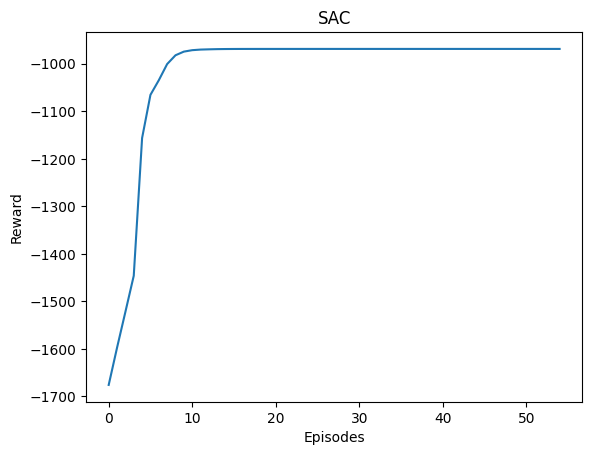

In [52]:
plt.plot([p[1] for p in results_sac])
plt.title("SAC")
plt.xlabel("Episodes")
plt.ylabel("Reward")